In [ ]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [ ]:
dataset = '/content/drive/MyDrive/hand-gesture-recognition-mediapipe-main/model/keypoint_classifier/keypoint.csv'
model_save_path = '/content/drive/MyDrive/hand-gesture-recognition-mediapipe-main/model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '/content/drive/MyDrive/hand-gesture-recognition-mediapipe-main/model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [ ]:
NUM_CLASSES = 8

# Dataset reading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/5 [=====>........................] - ETA: 1s - loss: 2.4267 - accuracy: 0.1250
Epoch 1: saving model to /content/drive/MyDrive/hand-gesture-recognition-mediapipe-main/model/keypoint_classifier/keypoint_classifier.hdf5
5/5 [==============================] - 1s 142ms/step - loss: 2.3740 - accuracy: 0.1542 - val_loss: 2.1601 - val_accuracy: 0.2233
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 2.3036 - accuracy: 0.1797
Epoch 2: saving model to /content/drive/MyDrive/hand-gesture-recognition-mediapipe-main/model/keypoint_classifier/keypoint_classifier.hdf5
5/5 [==============================] - 0s 19ms/step - loss: 2.2984 - accuracy: 0.1916 - val_loss: 2.1018 - val_accuracy: 0.1748
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 2.1907 - accuracy: 0.2031
Epoch 3: saving model to /content/drive/MyDrive/hand-gesture-recognition-mediapipe-main/model/keypoint_classifier/keypoint_classifier.hdf5
5/5 [==============================] - 0s 18

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 5ms/step - loss: 0.2135 - accuracy: 0.9854


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 62ms/step
[1.4682827e-02 2.7473489e-02 2.2205168e-07 1.3195242e-07 2.4912845e-08
 9.5727170e-01 4.7024229e-10 5.7158031e-04]
5


# Confusion matrix

7/7 [==============================] - 0s 3ms/step


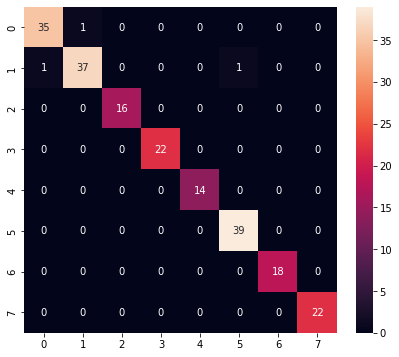

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.97      0.95      0.96        39
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        14
           5       0.97      1.00      0.99        39
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        22

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6692

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 37 µs, sys: 4 µs, total: 41 µs
Wall time: 46 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.46828415e-02 2.74735186e-02 2.22051497e-07 1.31952305e-07
 2.49127954e-08 9.57271755e-01 4.70242345e-10 5.71580546e-04]
5
